In [2]:
# Import modules from MultiNBS
from MultiNBS import data_import_tools as dit
from MultiNBS import network_propagation as prop
from MultiNBS import multiNBS_core as core
from MultiNBS import multiNBS_single
from MultiNBS import consensus_clustering as cc
from MultiNBS import multiNBS_plotting as plot

# Import other necessary packages
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score
import scipy.stats as stats

### Load Data
First, we must load the somatic mutation, gene expression, and network data for running MultiNBS. We will also set an output directory location to save our results.

In [ ]:
# load the somatic profile data below
# we set the file loading parameters explicitly below

sm_data_filepath = '*BLCA/Data/BLCA_SM_profiles.txt'
sm_mat = dit.load_binary_mutation_data(sm_data_filepath, filetype='list', delimiter='\t')

In [ ]:
# load the gene expression profile data below
rna_data_file_path = '*BLCA/Data/BLCA_RNA_profiles.txt'
rna_mat = pd.read_csv(rna_data_file_path, sep=",", header=0)

### Load molecular network
The network file is a 2-column text file representing an unweighted network. Each row represents a single edge in the molecular network.  

In [ ]:
# load the molecular network data below

network_filepath = '*BLCA/Data/CancerSubnetwork.txt'
network = dit.load_network_file(network_filepath)

### Combining RNA and Somatic Mutation Data
#### s(t) = $\beta$ x p(t) + (1-$\beta$) x q(t)

The somatic mutation data and RNA TPM unstranded data are combined, where the TPM unstranded data is min-max normalized and then combined using the linear combination formula described above where p(t) is the somatic mutation profiles and q(t) is the gene expression profiles.

In [5]:
# combine RNA and somatic matrices
comb_mat = dit.calc_combined_matrix(sm_mat, rna_mat, beta=0.3, replace_nan = False, verbose = True)
comb_mat.shape

Performing matrix combining with beta: 0.3
Combined Matrix Complete: 22.223451375961304 seconds


(400, 16149)

### Setting result directory and file names
This enables users to specify a directory for saving intermediate and final results, while also setting a file name prefix. If the user provides **save_args to the function with a valid directory path in ```outdir```, the results from that function call will be saved in the specified ```outdir```.

In [7]:
# Optional: Setting the output directory for files to be saved in
outdir = '*BLCA/Results/'

# Optional: Creating above output directory if it doesn't already exist
if not os.path.exists(outdir):
    os.makedirs(outdir)

# Optional: Setting a filename prefix for all files saved to outdir
job_name = 'BLCA-MultiNBS'

# Constructs dictionary to be passed as "save_args" to functions if output to be saved
save_args = {'outdir': outdir, 'job_name': job_name}

### Construct regularization graph for use in network-regularized NMF

In this step, we build the graph required for the network-regularized non-negative matrix factorization (netNMF) process in Multi-NBS. Specifically, we create a K-nearest neighbor (KNN) network based on the network influence matrix (Vandin et al., 2011*) of the molecular network used to stratify tumor samples. The graph Laplacian of this KNN network (knnGlap) serves as the regularizer in the subsequent netNMF steps. The function ```network_inf_KNN_glap``` from the MultiNBS_core module is used in this process.

This step is optional. The regularization network Laplacian does not need to be constructed if the user prefers to run the NMF step without a network regularizer. In that case, the user can pass ```None``` to the optional parameter ```regNet_glap``` or simply omit the parameter in the ```MultiNBS_single()``` function call below. This will trigger MultiNBS to perform a non-network-regularized NMF. However, due to the way the multiplicative update steps are implemented, the results may differ slightly from other NMF implementations (e.g., scikit-learn).

In [8]:
# Constructing knnGlap
knnGlap = core.network_inf_KNN_glap(network)



# The resulting matrix can be very large, so we choose not to save the intermediate result here
# To run this function and save the KNN graph laplaican to the output directory 'outdir' given above:
# Uncomment and run the following line instead:
# knnGlap = core.network_inf_KNN_glap(network, **save_args)

Graph influence matrix calculated: 4.671285629272461 seconds
Graph laplacian of KNN network from influence matrix calculated: 2.9181034564971924 seconds


### Construct network propagation kernel matrix
Because MultiNBS involves multiple subsampling and propagation steps,a pre-computed gene-by-gene matrix is much faster. This "network propagation kernel" shows the influence of each gene on others in the network during random-walk propagation. Here this propagation kernel is computed by propagating the all genes in the network independently of one another. The propagation profile of each tumor is the column sum vector of the resulting network propagation kernel selected for only the rows of genes marked as mutated in each tumor.


#### Calibrating the network propagation coefficient
The current network propagation coefficient ($\alpha$) is currently set to 0.7 and must range between 0 and 1. This parameter can be tuned. Previous results from [Hofree et al 2013](https://www.nature.com/articles/nmeth.2651) suggest that values between 0.5 and 0.8 produce the most consistent results.

In [9]:
# Set or change network propagation coefficient
alpha = 0.7

In [10]:
# Construct identity matrix of network
network_nodes = network.nodes()
network_I = pd.DataFrame(np.identity(len(network_nodes)), index=network_nodes, columns=network_nodes)

**Note about the propagation method used here:** The symmetric normalization for the adjacency matrix is performed here.

In [ ]:
# Construct network propagation kernel
kernel = prop.network_propagation(network, network_I, alpha=alpha, symmetric_norm=False)



# The resulting matrix can be very large, so we choose not to save the intermediate result here
# To run this function and save the propagation kernel to the output directory 'outdir' given above,
# Uncomment and run the following two lines instead of the above line:
# save_args['iteration_label']='kernel'
# kernel = prop.network_propagation(network, network_I, alpha=alpha, symmetric_norm=True, **save_args)

### Subsampling, propagation, and netNMF
We perform the following core steps of the MultiNBS algorithm multiple times (default=100x) to produce multiple patient clusterings that will be used in the later consensus clustering step. Each patient clustering is performed with the following steps:  
  
 1. **Subsample integrated profile data.** 
 2. **Propagate integrated data profile over network.**  or [```network_kernel_propagation```]
 3. **Quantile normalize the network-smoothed integrated data profile.** (See the documentation for the [```qnorm```]
 4. **Use netNMF to decompose network data into k clusters.** (See the documentation for the [```mixed_netNMF```]
  
These functions for each step here are wrapped by the [```MultiNBS_single```] function (a single iteration).

### Number of clusters
In this example there are 4 clusters, so we change that here. Other parameters can also be changed using \*\*kwargs. \*\*kwargs can also will hold the values of \*\*save_args to save the resulting dimension reduced patient profiles.

In [12]:
clusters = 4

### Number of iterations
The consensus clustering of the algorithm will improve if the data is subsampled and re-clustered multiple times. The default number of times we perform the aforementioned operation (```niter```) is 100 times.

In [13]:
# Set the number of times to perform pyNBS core steps
niter = 100

In [ ]:
# Optional: Saving the intermediate propagation step (from subsampled data) to file
save_args['save_prop'] = True

# Run 'niter' number of times
Hlist = []
for i in range(niter):
    netNMF_time = time.time()
    # Run MultiNBS core steps and save resulting H matrix to Hlist
    Hlist.append(multiNBS_single.NBS_single(sm_mat, knnGlap, propNet=network, propNet_kernel=kernel, k=clusters))



    # Uncomment and run the two lines below to save intermediate steps instead of the previous line
    # save_args['iteration_label']=str(i+1)
    # Hlist.append(multiNBS_single.NBS_single(comb_mat, propNet=network, propNet_kernel=kernel, regNet_glap=knnGlap,
    #                                      k=clusters, **save_args))

    

    # Report run time of each iteration
    t = time.time()-netNMF_time
    print('NBS iteration:', i+1, 'complete:', t, 'seconds')

NBS iteration: 1 complete: 70.0820984840393 seconds
NBS iteration: 2 complete: 65.46680521965027 seconds
NBS iteration: 3 complete: 67.15642595291138 seconds
NBS iteration: 4 complete: 66.31340479850769 seconds
NBS iteration: 5 complete: 69.88179612159729 seconds
NBS iteration: 6 complete: 69.31486511230469 seconds
NBS iteration: 7 complete: 66.57239985466003 seconds
NBS iteration: 8 complete: 65.8904778957367 seconds
NBS iteration: 9 complete: 67.23525285720825 seconds
NBS iteration: 10 complete: 65.75141072273254 seconds
NBS iteration: 11 complete: 68.27555680274963 seconds
NBS iteration: 12 complete: 66.62554979324341 seconds
NBS iteration: 13 complete: 68.42674016952515 seconds
NBS iteration: 14 complete: 68.93515849113464 seconds
NBS iteration: 15 complete: 68.91320610046387 seconds
NBS iteration: 16 complete: 65.9144446849823 seconds
NBS iteration: 17 complete: 68.21141695976257 seconds
NBS iteration: 18 complete: 65.27402067184448 seconds
NBS iteration: 19 complete: 67.881243944

### Consensus Clustering
If the H matrices were generated separately and saved to a directory, the user will need to manually import those H matrices into a python list first before passing the list to the function below.

In [15]:
MultiNBS_cc_table, MultiNBS_cc_linkage, MultiNBS_cluster_assign = cc.consensus_hclust_hard(Hlist, k=clusters, **save_args)

Constructing Hlist: 100 cluster matrices,  400 samples
Hlist consensus constructed and sample clusters assigned


### Co-Clustering Map
To visualize the clusters formed by the algorithm, we can plot a similarity map using the objects created in the previous step. We will also load data from the original Hofree et al 2013 paper to compare the results of theimplementation of the algorithm to the results reported in the paper. This step uses the ```cluster_color_assign``` functions in the ```MultiNBS_plotting``` module.

In [ ]:
# Assign colors to clusters
MultiNBS_BLCA_clust_cmap = plot.cluster_color_assign(MultiNBS_cluster_assign, name='MultiNBS BLCA Cluster Assignments')

# Plot and save co-cluster map figure
plot.plot_cc_map(MultiNBS_cc_table, MultiNBS_cc_linkage, col_color_map=MultiNBS_BLCA_clust_cmap, **save_args)

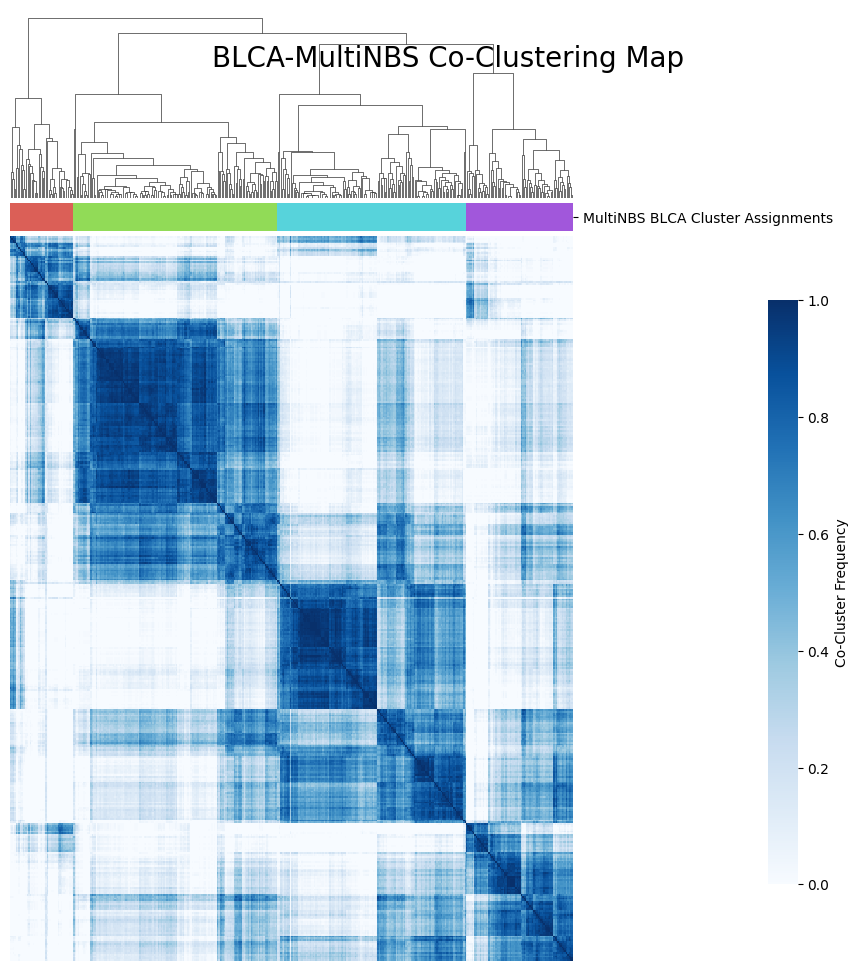

In [ ]:
Image(filename = save_args['outdir']+save_args['job_name']+'_cc_map.png', width=600, height=600)

### Survival analysis
We perform a standard survival analysis using a multi-class logrank test. This data is plotted using a Kaplan-Meier plot using the ```cluster_KMplot()``` in the ```MultiNBS_plotting``` module.

Multi-Class Log-Rank P: 0.004224940855359738
Kaplan Meier Plot constructed


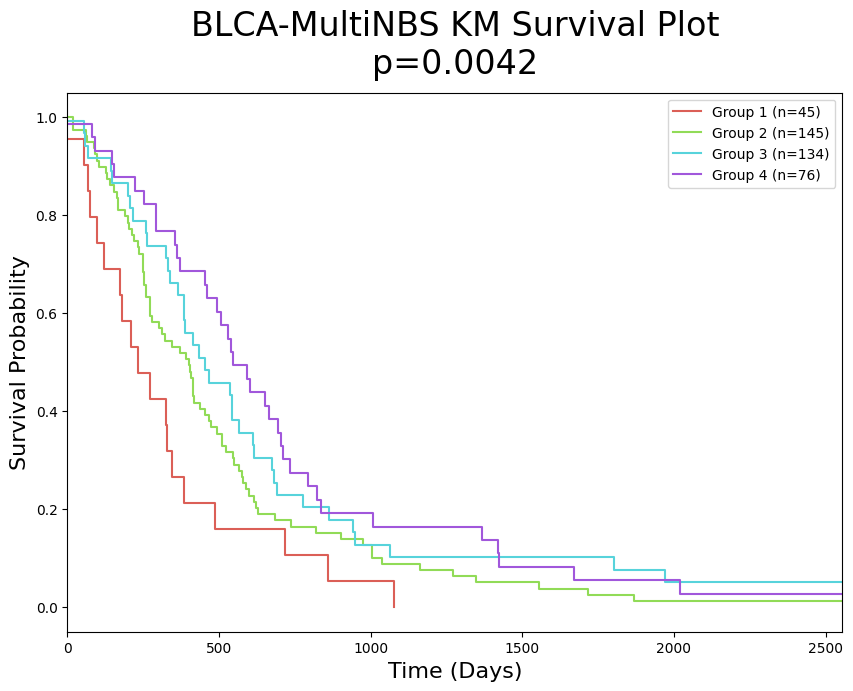

In [ ]:
# Load survival Data
surv_data = '*/BLCA/Data/BLCA_surv_analysis.txt'

# Plot KM Plot for patient clusters
plot.cluster_KMplot(MultiNBS_cluster_assign, surv_data, delimiter=',', **save_args)
Image(filename = save_args['outdir']+save_args['job_name']+'_KM_plot.png', width=600, height=600)